In [1]:
from pogo import Pogo

In [2]:
import numpy as np
import pandas as pd
import gudhi

In [3]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib.collections import PatchCollection
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [4]:

from sklearn import datasets

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics



In [5]:
from urllib.request import urlopen
from urllib.parse import urlparse
import os.path

In [6]:
%matplotlib inline

In [7]:
cmap = plt.cm.get_cmap("prism").copy()
#cmap.set_bad(cmap(0))

cmap.set_under('white')
cmap.set_over('black')
cmap.set_bad("black")
#cmap(number_of_clusters)

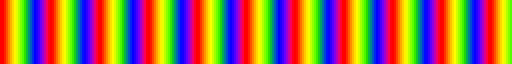

In [8]:
cm.get_cmap(cmap)

#randomized blobs with standard deviation
n = 6
std = np.random.random_sample((n,))
#std = 1
X, y, z = make_blobs(
    n_samples=n*100,
    n_features=2,
    centers=n,
    cluster_std=std,
    center_box=(-10.0, 10.0),
    shuffle=False,
    random_state=42,
    return_centers=True,
)



size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [9]:
#DBSCAN Demo Data from scikitlearn
centers = [[1, 1], [-1, -1], [1, -1]]
X, y = datasets.make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)
filename = 'dbscan-demo-data'

In [10]:
#data from scikitlearn tutorial on clustering 

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), np.zeros(n_samples,dtype='int')

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

In [11]:
X=varied[0]
y=varied[1]
filename = 'varied'


In [12]:

urls_with_ground_truth = ['https://cs.joensuu.fi/sipu/datasets/D31.txt',
        'https://cs.joensuu.fi/sipu/datasets/spiral.txt',
        'https://cs.joensuu.fi/sipu/datasets/pathbased.txt',
        'https://cs.joensuu.fi/sipu/datasets/R15.txt']

urls_without_ground_truth = ['https://cs.joensuu.fi/sipu/datasets/D31.txt',
        'https://cs.joensuu.fi/sipu/datasets/spiral.txt',
        'https://cs.joensuu.fi/sipu/datasets/overlap.txt',
        'https://cs.joensuu.fi/sipu/datasets/pathbased.txt',
        'https://cs.joensuu.fi/sipu/datasets/a1.txt',
        'https://cs.joensuu.fi/sipu/datasets/R15.txt']

ground_truth_urls = ['https://cs.joensuu.fi/sipu/datasets/overlap.pa'
    
]

urls_with_ground_truth = {
    urlparse(url).path.strip('/').split('/')[-1] : url for url in urls_with_ground_truth
}


urls_without_ground_truth = {
    urlparse(url).path.strip('/').split('/')[-1] : url for url in urls_without_ground_truth
}


ground_truth = {
    urlparse(url).path.strip('/').split('/')[-1] : url for url in ground_truth_urls
}

In [13]:
urls_with_ground_truth

{'D31.txt': 'https://cs.joensuu.fi/sipu/datasets/D31.txt',
 'spiral.txt': 'https://cs.joensuu.fi/sipu/datasets/spiral.txt',
 'pathbased.txt': 'https://cs.joensuu.fi/sipu/datasets/pathbased.txt',
 'R15.txt': 'https://cs.joensuu.fi/sipu/datasets/R15.txt'}

In [14]:
ground_truth

{'overlap.pa': 'https://cs.joensuu.fi/sipu/datasets/overlap.pa'}

In [15]:
def return_dataset(filename):
    if filename in urls_with_ground_truth:
        url= urls_with_ground_truth[filename]
        print(url)
        parse = urlparse(url)
        print(filename)
        raw_data = urlopen(url)
        data = np.loadtxt(raw_data)

        print(data.shape)
        print(data[:10])

        y = data[:,2]
        print(y.shape)
        X = data[:,:2]
        print(X.shape)
        return X, y, filename
    else:
        pass

In [16]:
#X, y, filename = return_dataset('R15.txt')

In [17]:
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target

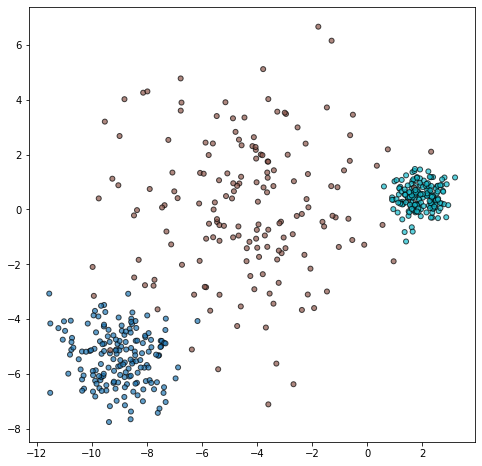

In [18]:
size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [19]:
pogo = Pogo(overlapping=True)
pogo.fit(X)

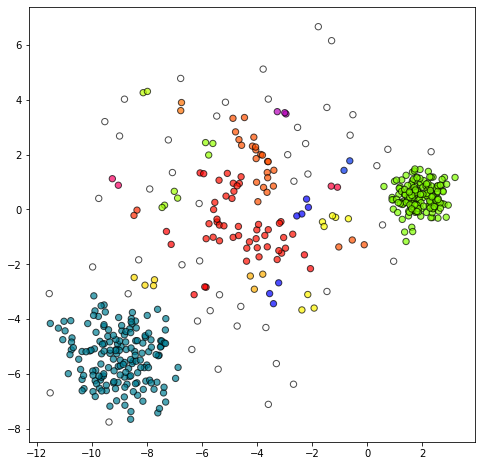

In [20]:
pogo.plot_diagram()

In [21]:
pred = pogo.labels_

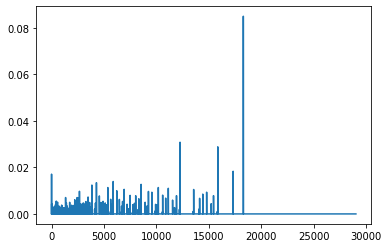

In [22]:
plt.plot(pogo.gap_vector_)

In [23]:
pogo.confidence_

'0.5%'

In [24]:
pogo.idx_

4915

In [25]:
pogo.candidates_[10]

5369

In [26]:
true = y

print(metrics.adjusted_rand_score(true, pred))
print(metrics.silhouette_score(X, pred, metric="sqeuclidean"))

0.7338421081696161
0.44935216752331153


usetex mode requires TeX.


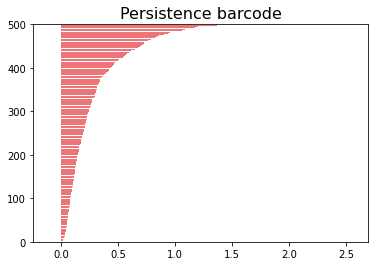

In [27]:
diag = pogo.simplex_tree_.persistence()
gudhi.plot_persistence_barcode(diag)
plt.show()

In [28]:
pogo.simplex_tree_.num_simplices()

29539

In [29]:
pogo.num_vertices_

500

In [30]:
#check that all clusters have merged
len(np.unique(pogo.candidates_[-1]))

1

In [31]:
print(pogo.cluster_dict_list_[-2].values()) #penultimate clustering has 2 clusters
print(pogo.cluster_dict_list_[-1].values()) #last clustering finally merges to all one cluster

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [32]:

print('your dataset appears to have', pogo.n_clusters_,'clusters, not including any outliers')
#return counts from np.unique? to filter out small clusters?

your dataset appears to have 25 clusters, not including any outliers


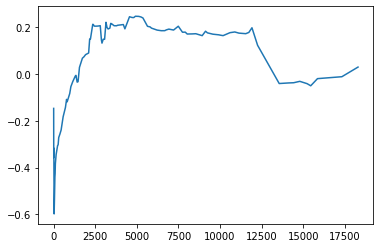

In [33]:
plt.plot(pogo.idx_array_,pogo.silhouette_array_)

In [34]:
print(pogo.idx_)

4915


In [35]:
print(pogo.initial_idx_)

18297


29038
29038
140
[    2     4     7     8    12    13    30    38    50    76    80    86
    89   104   137   150   155   164   185   221   238   271   306   360
   375   413   450   512   521   571   665   696   710   777   813   843
   864   893   966  1006  1036  1070  1091  1114  1149  1178  1234  1299
  1340  1414  1467  1553  1601  1705  1729  1820  1921  2027  2104  2144
  2166  2213  2323  2351  2383  2443  2544  2662  2802  2872  2906  2982
  3063  3147  3208  3274  3380  3433  3485  3635  3734  3777  3818  3849
  4106  4146  4190  4283  4560  4718  4818  4915  5082  5118  5253  5369
  5643  5793  5883  6221  6470  6681  6775  6926  7210  7343  7404  7493
  7745  7910  8029  8249  8327  8546  8929  9130  9244  9570  9928 10055
 10186 10601 10889 11139 11548 11733 11836 11921 12195 12260 13559 14045
 14127 14427 14797 15236 15453 15860 17325 18297]
varied140frames.gif


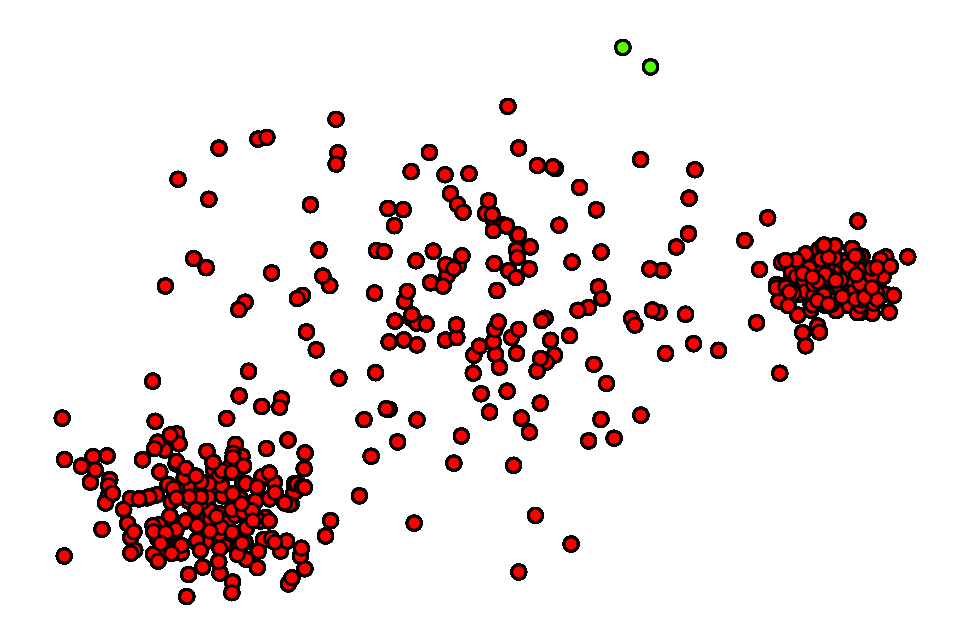

In [38]:
num_frames = 140
fps = 14
interval = 1000/fps
frames_array = pogo.candidates_.copy()
print(len(frames_array))
#frames_array = frames_array[frames_array < pogo.idx_]
print(len(frames_array))

frames_array = frames_array[:num_frames]
print(len(frames_array))

frames_array.sort()
vmax = max(np.array(list(pogo.cluster_dict_list_[frames_array[-1]].values())))
num_frames = len(frames_array)
print(frames_array)

fig, ax = plt.subplots(dpi=200)
ax.set_axis_off()

outfile = filename + str(num_frames) + 'frames.gif'
print(outfile)
if not os.path.isfile(outfile):
    def init():
        scatter = ax.scatter(X[:, 0], X[:, 1],
                        s=25, 
                        c=np.array(list(pogo.cluster_dict_list_[0].values())),
                        marker="o",
                        cmap=cmap,
                        norm=None,
                        alpha=1,
                        edgecolor="k",
                        vmax=vmax,
                        vmin = 0)
        #ax.set(xlim=(-1, 35), ylim=(-1, 35))

        return scatter,

    #collection = PatchCollection(X, animated=True)

    #ax.add_collection(collection)
    #ax.autoscale_view(True)

    def animate(i):

        scatter = ax.scatter(X[:, 0], X[:, 1],
                    s=25, 
                    c=np.array(list(pogo.cluster_dict_list_[frames_array[i]].values())),
                    marker="o",
                    cmap=cmap,
                    norm=None,
                    alpha=1,
                    edgecolor="k",
                    vmax=vmax,
                    vmin=0)
        return scatter,



    ani = FuncAnimation(fig, animate,interval=interval,init_func=init,frames=num_frames,repeat=False, blit=True)

    #ani.save('animation.gif')



    #writer=animation.PillowWriter()

    #writer = animation.FFMpegWriter(fps=2,bitrate=1000)

    ani.save(outfile)
    #fig.show()


In [37]:
max(np.array(list(pogo.cluster_dict_list[frames_array[-1]].values())))

AttributeError: 'Pogo' object has no attribute 'cluster_dict_list'

In [ ]:
len(pogo.candidates_)

In [ ]:
def get_first_max(array):
    for i in range(len(array)):
        if idx_array[i] > 2*simplex_tree.num_vertices():

            if array[i] > array[i+1] and array[i+2]and array[i+3]and array[i+4]:

                return float(array[i])

In [ ]:
first_max = get_first_max(silhouette_array)
idx_array[np.where(silhouette_array == first_max)]

In [ ]:
idx = int(idx_array[np.where(silhouette_array == first_max)])
idx

In [ ]:
pred = np.array(list(cluster_dict_list[idx].values()))
rand_score = metrics.adjusted_rand_score( true, pred)
rand_score

In [ ]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=pred,
            marker="o",
            cmap=cmap,
            norm=None,
            alpha=.9,
            edgecolor="k")

plt.show()

In [ ]:
rand_score_list = []
true = y
for i in idx_list:
    pred = np.array(list(cluster_dict_list[i].values()))
    rand_score = metrics.adjusted_rand_score( true, pred)
    rand_score_list.append(rand_score)

In [ ]:
rand_score_array = np.asarray(rand_score_list)

In [ ]:
 plt.plot(idx_array,rand_score_array)

In [ ]:
max(rand_score_array)

In [ ]:
idx = idx_array[rand_score_array.argmax()]
idx

In [ ]:
pred = np.array(list(cluster_dict_list[idx].values()))
rand_score = metrics.adjusted_rand_score( true, pred)
rand_score

In [ ]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=pred,
            marker="o",
            cmap=cmap,
            norm=None,
            alpha=.9,
            edgecolor="k")

plt.show()

def pogo(dataset):
    rips_complex = gudhi.RipsComplex(points=dataset,max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])
    #move through list and assign clusters to conected components

    point_dict={i:0 for i in range(simplex_tree.num_vertices())}
    counter=0

    cluster_dict_list = []
    for i in range(simplex_tree.num_vertices(),len(df)):
        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            counter += 1
            point_dict[df.loc[i,'simplex'][0]] = counter
            point_dict[df.loc[i,'simplex'][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] != 0:
            point_dict[df.loc[i,'simplex'][0]] = point_dict[df.loc[i,'simplex'][1]]

            #and vice versa
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            point_dict[df.loc[i,'simplex'][1]] = point_dict[df.loc[i,'simplex'][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] != 0 and point_dict[df.loc[i,'simplex'][0]] != point_dict[df.loc[i,'simplex'][1]]:
            larger_cluster_number = max(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            smaller_cluster_number = min(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())
        #print(point_dict)
        #print('step',i)

    
    cutoff_value = 0
    for i in range(len(cluster_dict_list)):
        if cutoff_value == 0:
            if all(value != 0 for value in cluster_dict_list[i].values()):
                cutoff_value = i
                print('dataset becomes connected at simplex #',cutoff_value)
       
    df = df[:cutoff_value]
    #cluster_dict_list =
    
    #find the gaps between birth/death pairs

    df['gaps'] = df['distance'] - df['distance'].shift(1)
    
    #find normalized distance
    scaler = MinMaxScaler()
    df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

    #Mulitply the gaps by their normed location in the filtration, weighting features more heavily if they're later
    df['normed_gaps'] = df['gaps'] * df['normed_distance']

    norm_sum = df['normed_gaps'].sum()
    df['probability_vector_normed_gaps'] = df['normed_gaps'] / norm_sum
    
    gap_sum = df['gaps'].sum()
    df['probability_vector_gaps'] = df['normed_gaps'] / gap_sum

    partition = 10
    candidates = [i for i in df.nlargest(partition ,['gaps']).index if i in df.nlargest( partition,['normed_gaps']).index]
    #print('possible cuttoffs' , candidates)
    idx = cutoff_value - 1
    #idx = candidates[0]
    print('idx' ,idx)

    print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

    #print( np.array(list(cluster_dict_list[idx].values())))

    print(simplex_tree.num_vertices() , 'vertices')  
    print(simplex_tree.num_simplices(), 'simplices')
    print('dimension:', simplex_tree.dimension())

    size=10
    plt.figure(figsize=(size,size))
    plt.scatter(dataset[:, 0], dataset[:, 1],
                s=30, 
                c=np.array(list(cluster_dict_list[idx].values())),
                marker="o",
                cmap='rainbow',
                norm=None,
                alpha=.9,
                edgecolor="k")
    
    return cluster_dict_list, candidates, idx


cluster_dict_list, candidates, idx = pogo(X)

true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print('adjusted rand score =' , metrics.adjusted_rand_score(true, pred))
